# 10-A. CIFAR10を用いた物体認識


---
## 目的
CIFAR10 Datasetを用いて10クラスの物体認識を行う．プログラムの構成は，MNISTによる文字認識のプログラムと同様になっているため，基礎的な説明はそちらを参照して頂きたい．このページでは，MNISTによる文字認識のプログラムとの差分について書いていく．

GPUを用いたネットワークの計算を行う．


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではChainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


## 使用するデータセット

### データセット
今回の物体認識では，CIFAR10データセットを用いる．CIFAR10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットである．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をChainerで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．


In [0]:
# モジュールのインポート
from time import time
import numpy as np
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L

# GPUの確認
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


## データセットの読み込みと確認
学習データ（CIFAR10データセット）を読み込みます．

読み込んだ学習データのサイズを確認します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています．
これは32x32ピクセルのカラー画像という意味になります．

In [0]:
train_dataset, test_dataset = chainer.datasets.get_cifar10()
train_x,train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(50000, 3, 32, 32) (50000,)
(10000, 3, 32, 32) (10000,)


### CIFAR10データセットの表示
CIFAR10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

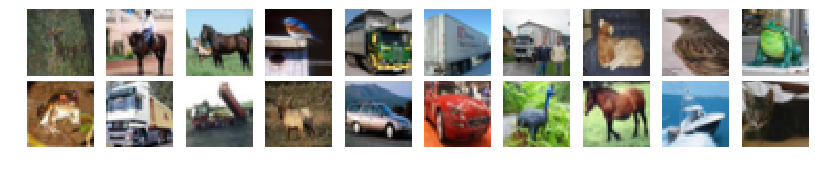

In [0]:
import matplotlib.pyplot as plt

cols = 10
rows = 2

plt.clf()
fig = plt.figure(figsize=(14, 4.8))
for r in range(rows):
  for c in range(cols):
    ax = fig.add_subplot(r+1, cols, c+1)
    ax.imshow(train_x[cols * r + c].transpose(1,2,0))
    ax.set_axis_off()
plt.show()

## ネットワークモデルの定義
畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

１層目の畳み込み層は入力チャンネル数が１，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．２層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．１つ目の全結合層は入力ユニット数は不定とし，出力は1024としています．次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．これらの各層の構成を\__init\__関数で定義します．

次に，\__call\__関数では，定義した層を接続して処理するように記述します．\__call\__関数の引数xは入力データです．それを\__init\__関数で定義したconv1に与え，その出力を活性化関数であるrelu関数に与えます．そして，その出力をmax_pooling_2dに与えて，プーリング処理結果をhとして出力します．hはconv2に与えられて畳み込み処理とプーリング処理を行います．そして，出力hをl1に与えて全結合層の処理を行います．最終的にl3の全結合層の処理を行った出力hを戻り値としています．

In [0]:
class CNN(Chain):
  def __init__(self):
    super(CNN, self).__init__()
    with self.init_scope():
      self.conv1 = L.Convolution2D(3, 16, 3, pad=1)
      self.conv2 = L.Convolution2D(16, 32, 3, pad=1)
      self.l1 = L.Linear(None, 1024)
      self.l2 = L.Linear(1024, 1024)
      self.l3 = L.Linear(1024, 10)

  def __call__(self, x):
    h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
    h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
    h = F.relu(self.l1(h))
    h = F.relu(self.l2(h))
    h = self.l3(h)
    return h

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．
ここでは，GPUで学習を行うために，modelをGPUに送るto_gpu関数を利用しています．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.05として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．


In [0]:
model = CNN()
model.to_gpu()

optimizer = chainer.optimizers.MomentumSGD(lr=0.05, momentum=0.9)
optimizer.setup(model)

ここでは，GPUに対応した行列演算モジュールのcupyを呼び出しており，学習およびテストデータをcupyの形式に変換します．
cupyはnumpyと互換性があります．


In [0]:
xp = cuda.cupy
train_x = xp.array(train_x, dtype=xp.float32)
train_y = xp.array(train_y, dtype=xp.int32)
test_x = xp.array(test_x, dtype=xp.float32)
test_y = xp.array(test_y, dtype=xp.int32)

## 学習
１回の誤差を算出するデータ数（ミニバッチサイズ）を64，学習エポック数を100とします．
CIFAR10の学習データサイズを取得し，１エポック内における更新回数を求めます．
学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．
各更新において，学習用データと教師データをそれぞれxとtとし，to_gpu関数でGPUに転送します．
学習モデルにxを与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．
また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [0]:
batch_size = 64
epoch_num = 100
train_data_num = train_x.shape[0]

start = time()
for epoch in range(epoch_num):
  num_iter = 0
  sum_loss = 0
  sum_accuracy = 0
  perm = xp.random.permutation(train_data_num)
  for i in range(0, train_data_num, batch_size):
    x = Variable(cuda.to_gpu(train_x[perm[i:i+batch_size]]))
    t = Variable(cuda.to_gpu(train_y[perm[i:i+batch_size]]))
    y = model(x)        
    model.zerograds()
    loss = F.softmax_cross_entropy(y, t)
    acc = F.accuracy(y, t)
    loss.backward()
    optimizer.update()
    sum_loss += loss.data
    sum_accuracy += acc.data
    num_iter +=1
  elapsed_time = time() - start
  print("epoch: {}, mean loss: {}, mean accuracy: {},  elapsed_time :{}".format(epoch+1, sum_loss/num_iter, sum_accuracy/num_iter, elapsed_time))

  if (epoch+1) % 10 == 0:
    chainer.serializers.save_hdf5('cifar10_epoch{}.npz'.format(epoch), model, compression=6)

epoch: 1, mean loss: 0.9211355, mean accuracy: 0.68178546,  elapsed_time :4.888368606567383
epoch: 2, mean loss: 0.6705496, mean accuracy: 0.7639266,  elapsed_time :9.420430183410645
epoch: 3, mean loss: 0.49144042, mean accuracy: 0.82796514,  elapsed_time :13.97122073173523
epoch: 4, mean loss: 0.38227153, mean accuracy: 0.8655291,  elapsed_time :18.52712607383728
epoch: 5, mean loss: 0.36673298, mean accuracy: 0.8753996,  elapsed_time :23.109710931777954
epoch: 6, mean loss: 0.3066354, mean accuracy: 0.89845747,  elapsed_time :27.67808222770691
epoch: 7, mean loss: 0.2949322, mean accuracy: 0.9051111,  elapsed_time :32.260621070861816
epoch: 8, mean loss: 0.2928085, mean accuracy: 0.9084079,  elapsed_time :36.803836822509766
epoch: 9, mean loss: 0.2888112, mean accuracy: 0.91412246,  elapsed_time :41.35179543495178
epoch: 10, mean loss: 0.27968276, mean accuracy: 0.9154212,  elapsed_time :45.8616361618042
epoch: 11, mean loss: 0.26881027, mean accuracy: 0.9222946,  elapsed_time :51.1

## テスト
学習したネットワークモデルを用いて評価を行います．

In [0]:
cnt = 0
test_data_num = test_x.shape[0]

for i in range(test_data_num):
  x = Variable(cuda.to_gpu(test_x[i].reshape(1,3,32,32)))
  t = test_y[i]
  y = model(x)
  y = np.argmax(y.data[0])
  if t == y:
    cnt += 1
 
print("test accuracy: {}".format(cnt/test_data_num))

test accuracy: 0.1


## 課題
1. ネットワーク構造を変えて実験しましょう． 
     * まず，1層目の畳み込み層のフィルタ数を32にしましょう．また，2層目の畳み込み層のフィルタ数を64にしましょう．
    * 次に，中間層のユニット数を2048にしましょう．
   


2. 最適化の方法をAdamに変えて実験しましょう．



3. エポック数やミニバッチサイズを変えて実験しましょう．
    * まず，ミニバッチサイズを128にしましょう．
    * 次に，エポック数を50にしましょう．
  
  
4. GPUの有無による速度の差を比較しましょう．




##別のコードの書き方

前回のCNNによるMNISTの文字認識と同様にTrainerを利用したプログラムを作成します．　Trainerを利用する場合と利用しない場合による処理時間の違いを確認しましょう．

In [0]:
import numpy as np
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

batch_size = 32
epoch_num = 100

learning_rate = 0.05


model = L.Classifier(CNN())
model.to_gpu() 
optimizer = chainer.optimizers.MomentumSGD(lr=learning_rate, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_cifar10()

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size, repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater(train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(test_iter, model, device=0))
trainer.extend(extensions.ExponentialShift('lr', 0.5),  trigger=(25, 'epoch'))

trainer.extend(extensions.dump_graph('main/loss'))

trainer.extend(extensions.LogReport())

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                                     'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                                     'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                                       'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()